# Import statements and read data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve, KFold
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

from scipy.stats import ks_2samp

import warnings
warnings.filterwarnings('ignore')

# ! pip install category_encoders
import category_encoders as ce

# Section A

Observations:


*   There are 6435 rows and 8 columns






In [2]:
input_data = pd.read_csv('walmart.csv')

In [3]:
print(input_data.shape)
display(input_data.head())

(6435, 8)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


# Section B

Observations:


*   Unemployment feature is bit skewed and required outlier removal. CPI metric has an uneven distribution and might not be statistically significant.
*   There are surprisingly no nulls in the dataset hence no imputation is required
*   Store feature is a categorical feature which needs to be encoded
*   I have created 2 metrics from the date column: Month and year which maybe be statistically significant 



In [4]:
master_data = input_data.copy()

In [5]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [6]:
master_data.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [7]:
# since store is a is more like an ID hence it cannot be a categorical variable hence considering all columns with unique values more than 45 as continous variables
continous_variable = []
for i in input_data.columns:
    if input_data[i].nunique() > 45 and (input_data[i].dtype == 'int64' or input_data[i].dtype == 'float64'):
        continous_variable.append(i)
        
print(continous_variable)

['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']


In [8]:
# analyse null values in the dataset
for i in master_data.columns[2:]:
    if master_data[i].isna().sum() > 0:
        null_count = master_data[i].isna().sum()
        null_percentage = (null_count / master_data.shape[0]) * 100
        print(f"Column: {i}, Number of Nulls: {null_count}, Percentage of Nulls: {null_percentage:.2f}%")

Since there are no null values in the dataset we don't need to perform any null value imputation

In [9]:
# function to plot histograms
def plot_histogram(data, column_name):
    plt.hist(data[column_name], bins=10, edgecolor='black')
    plt.title(f'Histogram of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()

Weekly_Sales


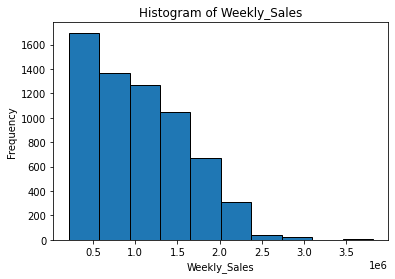

Holiday_Flag
0    5985
1     450
Name: count, dtype: int64
Temperature


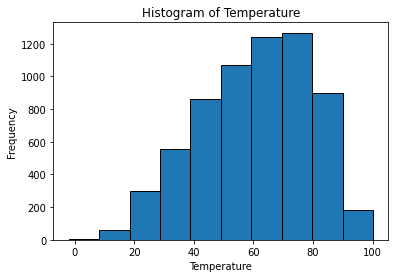

Fuel_Price


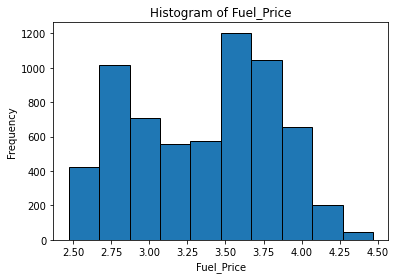

CPI


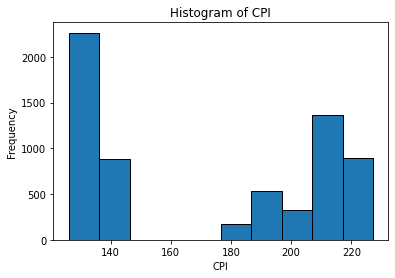

Unemployment


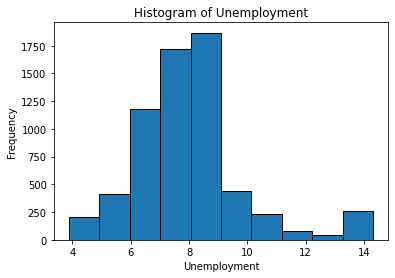

In [10]:
# histogram plots to analyze univariate summaries
for i in master_data.columns[2:]:
    if master_data[i].nunique()>10:
        print(i)
        plot_histogram(master_data, i)
    else:
        print(master_data[i].value_counts())

In [11]:
# Extracting weekday, week, month
master_data['Date']=pd.to_datetime(master_data['Date'], format='%d-%m-%Y')

# master_data['weekday'] = master_data.Date.dt.weekday
master_data['month'] = master_data.Date.dt.month
master_data['year'] = master_data.Date.dt.year

master_data.drop(columns = ['Date'], inplace = True)

master_data.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,month,year
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,2,2010
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,2,2010
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,2,2010
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,2,2010
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,3,2010


In [12]:
# As the data seems to be really skewed
master_data_treated = master_data.copy()

features1 = continous_variable

for i in features1:
    Q1 = master_data_treated[i].quantile(0.25)
    Q3 = master_data_treated[i].quantile(0.75)
    IQR = Q3 - Q1
    master_data_treated = master_data_treated[master_data_treated[i] <= (Q3+(1.5*IQR))]
    master_data_treated = master_data_treated[master_data_treated[i] >= (Q1-(1.5*IQR))]
    master_data_treated = master_data_treated.reset_index(drop=True)

display(master_data_treated.head())
print(master_data.shape[0])
print(master_data_treated.shape[0])

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,month,year
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,2,2010
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,2,2010
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,2,2010
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,2,2010
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,3,2010


6435
5917


Weekly_Sales


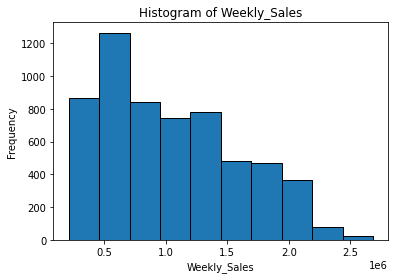

Temperature


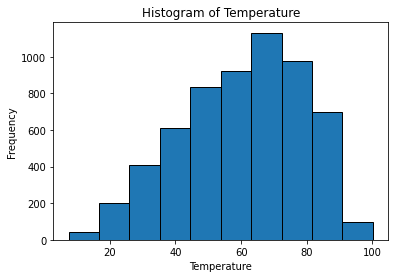

Fuel_Price


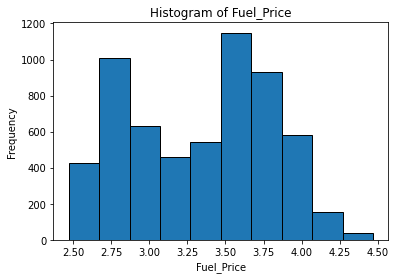

CPI


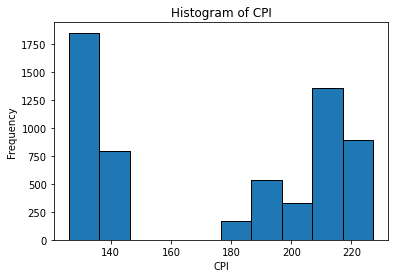

Unemployment


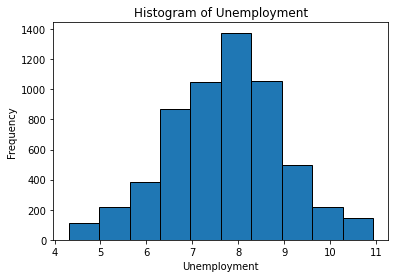

In [13]:
# histogram plots to analyze univariate summaries
for i in continous_variable:
    print(i)
    plot_histogram(master_data_treated, i)

How to encode Stores?
There are 45 unique countries in the data and performing one hot encoding will add 45 new columns which is way too much. Hence we researched and came up with 2 ways of encoding it:
1. Target encoding: It is used when there are too many categories for a categorical feature. Here we calculate the average value of target variable for each category and encode the category with the average value of target variable. Its drawback is that it may lead to overfitting.
2. Binary encoding: This method is also used for dimentioanlity reduction. We can label encode the countries and just assign the binary value for them. Its drawback is that it is not a very good while working with linear models (which we are dealing with in this problem) as it is not explainable for linear models.

Approach:
During Question 1 we realized that the target encoding method creates a metrics which overfits the model hence we will go forward with binary encoding

In [14]:
master_data_treated['Unemployment'].describe()

count    5917.000000
mean        7.722305
std         1.243337
min         4.308000
25%         6.891000
50%         7.852000
75%         8.494000
max        10.926000
Name: Unemployment, dtype: float64

In [15]:
# binary encoding
binary_encoder = ce.BinaryEncoder(cols=['Store'])
master_data_treated = binary_encoder.fit_transform(master_data_treated)

In [16]:
master_data_treated['Unemployment'].describe()

count    5917.000000
mean        7.722305
std         1.243337
min         4.308000
25%         6.891000
50%         7.852000
75%         8.494000
max        10.926000
Name: Unemployment, dtype: float64

# Section C
Observations:
1. No feature has very high correlation with the y-variable which indicates that model may not fit very well to the data
2. Store_5 and Store_0 could be significant negative predictors.
3. Only fuel price and year show very high correlation between each other

In [17]:
# PCC works best for continous variables
# correlation_matrix = master_data_treated.drop(columns=master_data_treated.filter(like='Store').columns).corr()
correlation_matrix = master_data_treated.corr()

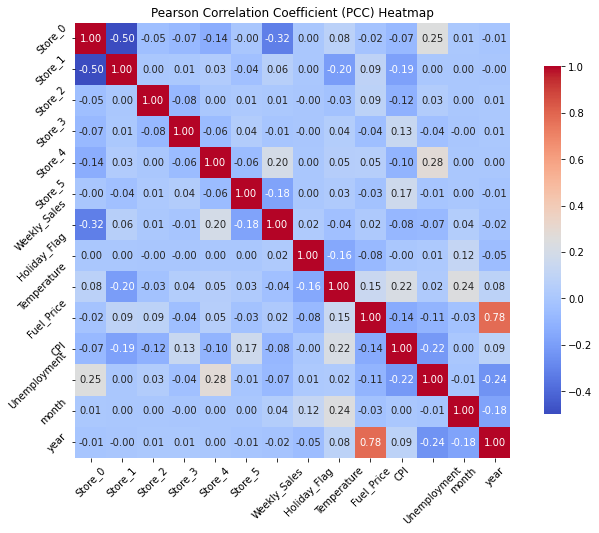

In [18]:
# correlation matrix 
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Pearson Correlation Coefficient (PCC) Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [19]:
correlation_matrix['Weekly_Sales'].sort_values(ascending=False)

Weekly_Sales    1.000000
Store_4         0.196382
Store_1         0.058597
month           0.042940
Holiday_Flag    0.024390
Fuel_Price      0.019664
Store_2         0.007976
Store_3        -0.008768
year           -0.021170
Temperature    -0.041686
Unemployment   -0.073092
CPI            -0.082977
Store_5        -0.176789
Store_0        -0.321216
Name: Weekly_Sales, dtype: float64

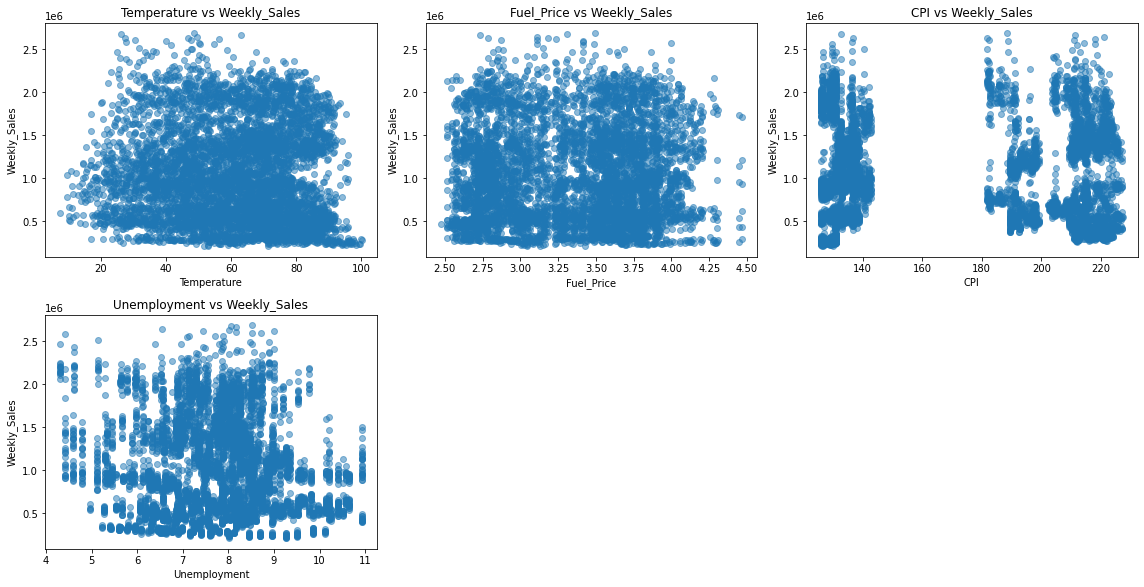

In [20]:
corr_data = master_data_treated

features = [i for i in continous_variable if 'Weekly_Sales' not in i]

# Target variable
target = 'Weekly_Sales'

# Create scatter plots for each feature against the target variable
plt.figure(figsize=(16, 20))  # Adjust the figure size as needed

for i, feature in enumerate(features):
    plt.subplot(5, 3, i+1)  # Create a 5x3 grid for subplots
    plt.scatter(corr_data[feature], corr_data[target], alpha=0.5)
    plt.title(f'{feature} vs {target}')
    plt.xlabel(feature)
    plt.ylabel(target)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

In [21]:
def corr_to_df(data, threshold):
    """
    Convert correlation matrix to a DataFrame containing correlated pairs.

    Parameters:
    - data (DataFrame): Input DataFrame to calculate correlation matrix from.
    - threshold (float): Threshold value to determine correlation significance.

    Returns:
    - DataFrame: DataFrame containing pairs of variables and their correlation values that exceed the threshold.
    """
    corr_result = data.corr()
    corr = corr_result[(corr_result != 1.0) & ((corr_result > threshold) | (corr_result < -1 * threshold))]
    corr_melted = corr.reset_index().melt(id_vars='index')
    corr_filtered = corr_melted[corr_melted['index'] < corr_melted['variable']].dropna()
    corr_filtered.columns = ['variable1', 'variable2', 'correlation']

    return corr_filtered

def corr_columns(df, threshold=0.6):
    temp_corr = corr_to_df(df, threshold=threshold)
    return temp_corr

In [22]:
master_data_treated.columns

Index(['Store_0', 'Store_1', 'Store_2', 'Store_3', 'Store_4', 'Store_5',
       'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'month', 'year'],
      dtype='object')

In [23]:
corr_data = master_data_treated.drop(columns = ['Weekly_Sales'])
corr_columns(corr_data)

,variable1,variable2,correlation
164,Fuel_Price,year,0.782957


In [24]:
corr_data.columns

Index(['Store_0', 'Store_1', 'Store_2', 'Store_3', 'Store_4', 'Store_5',
       'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
       'month', 'year'],
      dtype='object')

In [25]:
continous_variable

['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

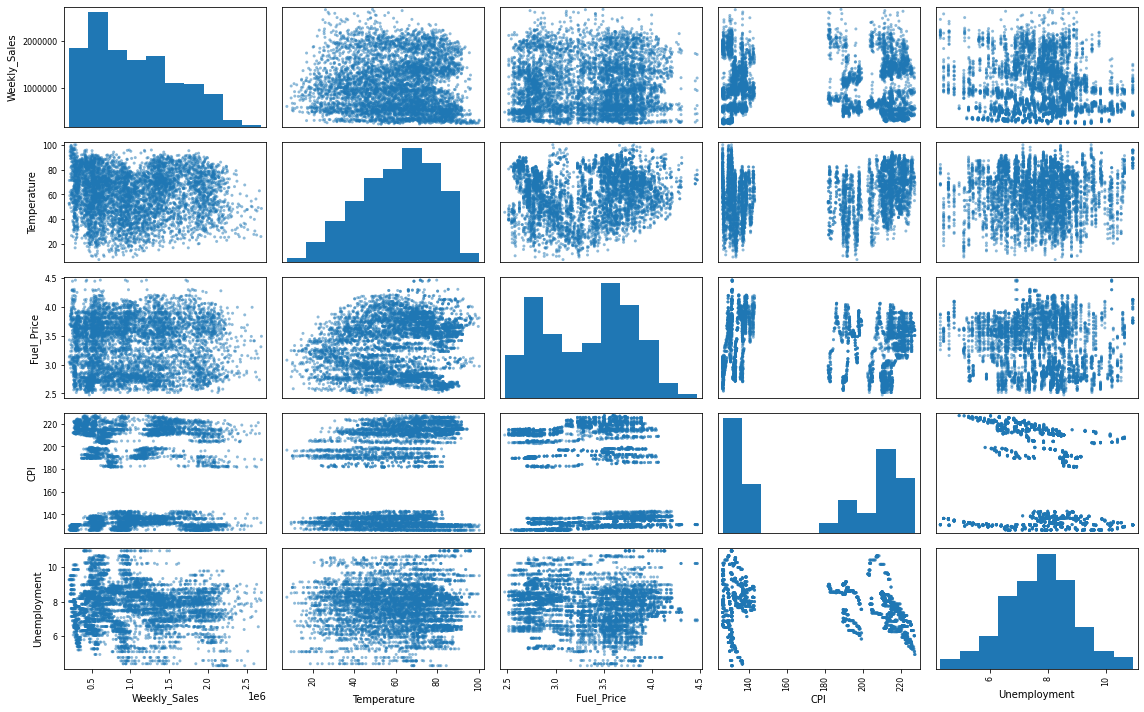

In [26]:
scatter_matrix(master_data_treated[continous_variable], figsize=(16, 10))
plt.tight_layout()
plt.show()

# Section D

## Train test split
1. We have binned the y-variable into H-M-L to stratify it
2. We have divided the train and test into a 75-25 split

In [27]:
# binning the target variable into H-M-L to stratify it
quantiles = [0, 0.33, 0.66, 1.0]
labels = ['L', 'M', 'H']

master_data_treated['Weekly_Sales_bins'] = pd.qcut(master_data_treated['Weekly_Sales'], q=quantiles, labels=labels)

In [28]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(master_data_treated.drop(['Weekly_Sales', 'Weekly_Sales_bins'], axis=1),
                                                    master_data_treated['Weekly_Sales'],
                                                    stratify=master_data_treated['Weekly_Sales_bins'],
                                                    test_size=0.25,
                                                    random_state=42)

## Verification
1. Our testing data is representative of our training data. we can conclude that by the describe function where we can see that all the measures of central tendencies are similar for test and train data.
2. We have also   performed Kolmogorov-Smirnov Test where we got a p-value for all features significantly more than 0.05 indicating that test data comes from the same distribution as the training data. The same can be visualized in the plots.

In [29]:
display(X_train.describe())
display(X_test.describe())

,Store_0,Store_1,Store_2,Store_3,Store_4,Store_5,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,month,year
count,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000
mean,0.304710,0.352941,0.474870,0.454586,0.493351,0.554203,0.067162,60.801920,3.341120,175.483444,7.711293,6.457516,2010.961010
std,0.460337,0.477938,0.499424,0.497989,0.500012,0.497109,0.250331,18.370671,0.457708,39.089557,1.241115,3.202627,0.795651
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.460000,2.472000,126.064000,4.308000,1.000000,2010.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47.540000,2.895000,132.767067,6.891000,4.000000,2010.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,62.940000,3.420000,190.571326,7.838000,7.000000,2011.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,75.090000,3.720000,214.026217,8.488000,9.000000,2012.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.140000,4.468000,227.232807,10.926000,12.000000,2012.000000


,Store_0,Store_1,Store_2,Store_3,Store_4,Store_5,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,month,year
count,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.00000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000
mean,0.325000,0.365541,0.490541,0.449324,0.520946,0.524324,0.07500,59.328615,3.338814,173.643194,7.755318,6.407432,2010.953378
std,0.468533,0.481744,0.500079,0.497593,0.499730,0.499577,0.26348,18.395696,0.459820,38.803778,1.249814,3.273980,0.793731
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,9.510000,2.514000,126.064000,4.308000,1.000000,2010.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,46.020000,2.877750,132.761933,6.907500,4.000000,2010.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000,61.505000,3.420000,189.420000,7.874000,6.000000,2011.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.00000,73.767500,3.721250,212.144082,8.521500,9.000000,2012.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,99.200000,4.449000,226.987364,10.926000,12.000000,2012.000000


Store_0 - KS Statistic: 0.02028961009691233, P-value: 0.7409716433660168
Store_1 - KS Statistic: 0.012599364069952304, P-value: 0.9934387842942527
Store_2 - KS Statistic: 0.015670132607252283, P-value: 0.9429955416392761
Store_3 - KS Statistic: 0.005262107949734724, P-value: 1.0
Store_4 - KS Statistic: 0.02759458241202663, P-value: 0.3585710808828197
Store_5 - KS Statistic: 0.029878966187282616, P-value: 0.26828623311787164
Holiday_Flag - KS Statistic: 0.007837502817218841, P-value: 0.9999997066798293
Temperature - KS Statistic: 0.0386126491603165, P-value: 0.07073567529563637
Fuel_Price - KS Statistic: 0.01630743319384293, P-value: 0.923538150405488
CPI - KS Statistic: 0.04480474389196499, P-value: 0.022368686250606607
Unemployment - KS Statistic: 0.04152001900480602, P-value: 0.042056497150102186
month - KS Statistic: 0.022863025297102376, P-value: 0.597319415312962
year - KS Statistic: 0.005156119608452266, P-value: 1.0


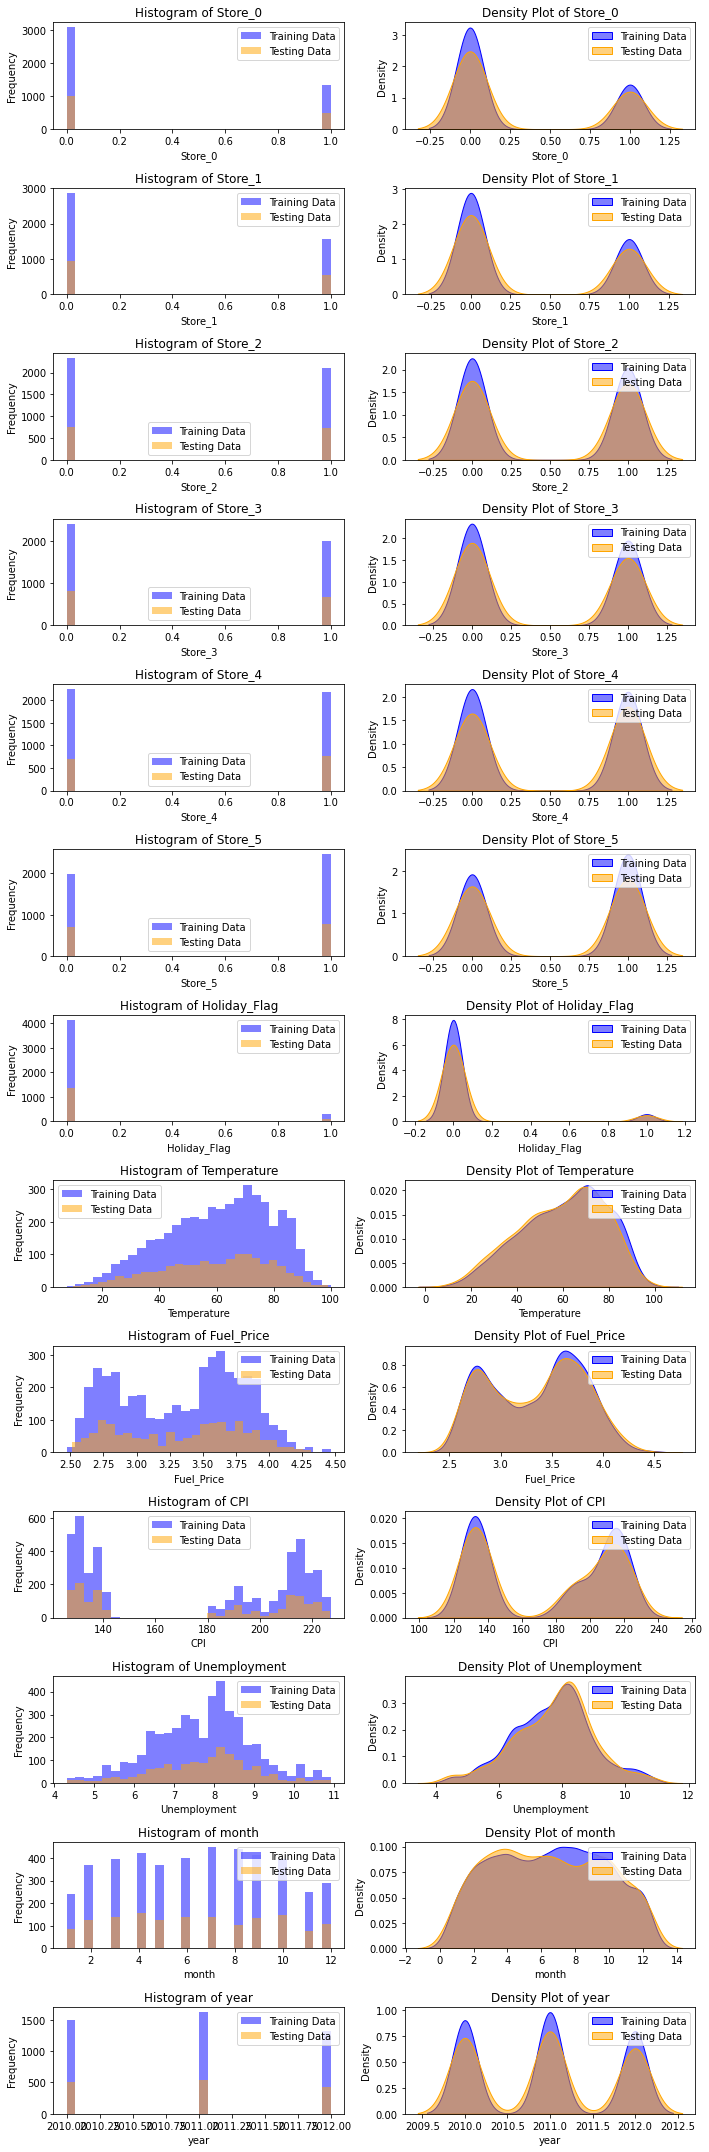

In [30]:
# Set the figure size
plt.figure(figsize=(10, 30))

# Loop through each feature in the datasets
for i, feature in enumerate(X_train.columns):
    plt.subplot(len(X_train.columns), 2, 2*i + 1)  # Create subplot for histogram
    plt.hist(X_train[feature], bins=30, alpha=0.5, label='Training Data', color='blue')
    plt.hist(X_test[feature], bins=30, alpha=0.5, label='Testing Data', color='orange')
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(len(X_train.columns), 2, 2*i + 2)  # Create subplot for density plot
    sns.kdeplot(X_train[feature], label='Training Data', color='blue', fill=True, alpha=0.5)
    sns.kdeplot(X_test[feature], label='Testing Data', color='orange', fill=True, alpha=0.5)
    plt.title(f'Density Plot of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

    # Perform Kolmogorov-Smirnov Test
    ks_statistic, p_value = ks_2samp(X_train[feature], X_test[feature])
    print(f'{feature} - KS Statistic: {ks_statistic}, P-value: {p_value}')

plt.tight_layout()
plt.show()

In [31]:
# Data scaling

scaler = MinMaxScaler()


# scaler = StandardScaler()

# Fit the scaler and transform the training and testing data
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

# Section E: Linear Regression

## Part 1: Linear Regression with Normal Equation and Cross-Validation
Observations:
1. The MSE of the model is 234922174031.57 without k-fold cross validation and 254589706185.11 with k-fold cross validation

In [32]:
class LinearRegressionNormalEquation:
    def _init_(self):
        self.theta = None

    def fit(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        self.theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b.dot(self.theta)

    def get_params(self):
        return self.theta

In [33]:
X_train_linear = X_train_transformed.copy()
X_test_linear = X_test_transformed.copy()

# Ensure X_train and X_test have intercept terms
model = LinearRegressionNormalEquation()
model.fit(X_train_linear, y_train.ravel())

y_pred = model.predict(X_test_linear)
mse_normal = mean_squared_error(y_test.ravel(), y_pred)
print(f"Linear Regression (Normal Equation) - MSE: {mse_normal:.2f}")

Linear Regression (Normal Equation) - MSE: 234922174031.57


In [34]:
# Function to perform k-fold cross-validation
def cross_validate_model(model, X, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    mse_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the model on the training set
        model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Calculate MSE for the fold
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)

    return np.mean(mse_scores)

In [35]:
mse_cv = cross_validate_model(model, X_train_linear, y_train.ravel(), k=3)
print(f"Linear Regression (Normal Equation) - 3-Fold CV MSE: {mse_cv:.2f}")

Linear Regression (Normal Equation) - 3-Fold CV MSE: 254589706185.11


### Stochastic Gradient Descent (SGD) for Linear Regression
1. The MSE for SGD model is 235198633929.02
2. In the training and validation loss curve we observe that the model is slightly over fit as the validation RMSE is 0.37 and training RMSE is around 0.28

In [36]:
def create_sgd_model(X_train, y_train, X_test, y_test, learning_rate, n_iterations, tolerance):
    sgd_reg = SGDRegressor(max_iter=n_iterations, eta0=learning_rate,
                       tol=tolerance, random_state=42, warm_start = True)

    sgd_reg.fit(X_train, y_train.ravel())

    # Predict on the test set
    y_pred_sgd = sgd_reg.predict(X_test)

    # Calculate the MSE for SGD
    mse_sgd = mean_squared_error(y_test, y_pred_sgd)

    return sgd_reg, y_pred_sgd, mse_sgd

In [37]:
sgd_model, y_pred_sgd, mse_sgd = create_sgd_model(X_train_linear, y_train, X_test_linear, y_test, 0.01, 1000, 1e-5)
print(f"SGD - MSE: {mse_sgd:.2f}")

SGD - MSE: 235198633929.02


### Plotting Training Loss for SGD
* Both training and validation losses drop rapidly in the initial epochs, with validation loss reaching a lower value than training loss early on, suggesting the model quickly adapts to the data.
* After the initial drop, both losses plateau and stabilize, with minimal further improvement, indicating the model has converged and further training yields no significant performance gain.

In [38]:
# Function to perform SGD with tracking of training and validation loss
def sgd_train_and_plot_loss(X_train, y_train, X_val, y_val, n_iter):

    sgd_model= create_sgd_model(X_train, y_train, X_val, y_val, 0.01, 1, 1e-5)[0]

    # Lists to store training and validation losses
    training_losses = []
    validation_losses = []

    # Training loop
    for epoch in range(n_iter):
        # Fit the model for one iteration (epoch)
        sgd_model.fit(X_train, y_train.ravel())

        # Calculate predictions
        y_train_pred = sgd_model.predict(X_train)
        y_val_pred = sgd_model.predict(X_val)

        # Calculate training and validation loss
        train_loss = mean_squared_error(y_train_pred, y_train.ravel())
        val_loss = mean_squared_error(y_val_pred, y_val.ravel())

        # Store the losses
        training_losses.append(train_loss)
        validation_losses.append(val_loss)

        # Output the losses at each epoch
        # print(f"Epoch {epoch+1}/{n_iter} - Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Plot the loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_iter + 1), training_losses, label='Training Loss')
    plt.plot(range(1, n_iter + 1), validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.title('SGD Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

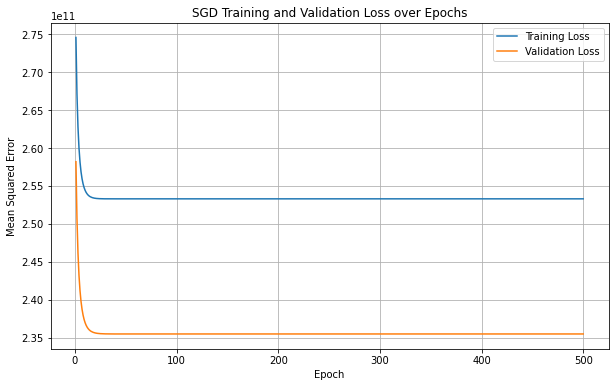

In [39]:
sgd_train_and_plot_loss(X_train_linear, y_train, X_test_linear, y_test, 500)

## Part 2: Ridge, Lasso, and Elastic Net Regularization
Observations:
* Ridge Regression:

    * With increasing alpha values (0.01, 0.1, and 1), the MSE values slightly increase:
        * Alpha 0.01: MSE = 234,922,213,850.06
        * Alpha 0.1: MSE = 234,922,574,798.14
        * Alpha 1: MSE = 234,926,434,970.27
    * The model performs slightly better at lower alpha values, meaning less regularization results in better performance.

* Lasso Regression:

    * Lasso exhibits stable performance across different alpha values with a very slight increase in MSE:
        * Alpha 0.01: MSE = 234,922,175,495.94
        * Alpha 0.1: MSE = 234,922,188,709.98
        * Alpha 1: MSE = 234,922,320,913.65
    * Again, the model performs better at lower alpha values, suggesting that reducing the penalty term helps the model fit better.
* Elastic Net Regression:

    * Elastic Net shows more variation in MSE as alpha increases:
        * Alpha 0.01: MSE = 235,110,938,531.86
        * Alpha 0.1: MSE = 238,991,833,038.96
        * Alpha 1: MSE = 263,461,737,899.97
    * The MSE increases considerably for higher alpha values, indicating that stronger regularization leads to worse performance.
    
Conclusion:
* For both Ridge and Lasso, a lower alpha (0.01) results in the best performance, with almost negligible differences across different alpha values. This suggests that less regularization is beneficial for this dataset.
* Elastic Net, however, is more sensitive to regularization, and as alpha increases, performance worsens.

In [40]:
def compute_mse(model_class, X_train, y_train, X_test, y_test, alpha, **kwargs):
    model = model_class(alpha=alpha, **kwargs)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return mse

In [41]:
# Define alpha values for regularization
alphas = [0.01, 0.1, 1]

ridge_mse = []
lasso_mse = []
elastic_net_mse = []

# Ridge Regression
for alpha in alphas:
    mse = compute_mse(Ridge, X_train_linear, y_train, X_test_linear, y_test, alpha=alpha)
    ridge_mse.append(mse)
    print(f"Ridge Regression (alpha={alpha}) - Test MSE: {mse:.2f}")

# Lasso Regression
for alpha in alphas:
    mse = compute_mse(Lasso, X_train_linear, y_train, X_test_linear, y_test, alpha=alpha)
    lasso_mse.append(mse)
    print(f"Lasso Regression (alpha={alpha}) - Test MSE: {mse:.2f}")

# Elastic Net Regression
for alpha in alphas:
    mse = compute_mse(ElasticNet, X_train_linear, y_train, X_test_linear, y_test, alpha=alpha, l1_ratio=0.5)
    elastic_net_mse.append(mse)
    print(f"Elastic Net Regression (alpha={alpha}) - Test MSE: {mse:.2f}")

Ridge Regression (alpha=0.01) - Test MSE: 234922213850.06
Ridge Regression (alpha=0.1) - Test MSE: 234922574798.14
Ridge Regression (alpha=1) - Test MSE: 234926434970.27
Lasso Regression (alpha=0.01) - Test MSE: 234922175495.94
Lasso Regression (alpha=0.1) - Test MSE: 234922188709.98
Lasso Regression (alpha=1) - Test MSE: 234922320913.65
Elastic Net Regression (alpha=0.01) - Test MSE: 235110938531.86
Elastic Net Regression (alpha=0.1) - Test MSE: 238991833038.96
Elastic Net Regression (alpha=1) - Test MSE: 263461737899.97


### Plot MSE for Regularization Techniques

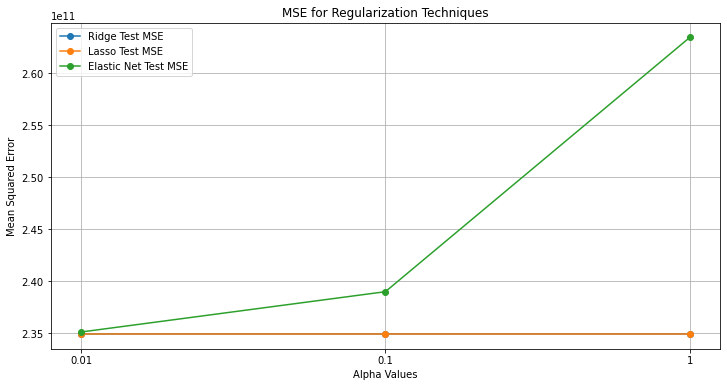

In [42]:
# Plot MSE for different regularization techniques
labels = ['Ridge', 'Lasso', 'Elastic Net']
mse_values = [ridge_mse, lasso_mse, elastic_net_mse]

plt.figure(figsize=(12, 6))
x = np.arange(len(alphas))

for i, label in enumerate(labels):
    plt.plot(x, mse_values[i], marker='o', label=f'{label} Test MSE')

plt.xticks(x, alphas)
plt.xlabel('Alpha Values')
plt.ylabel('Mean Squared Error')
plt.title('MSE for Regularization Techniques')
plt.legend()
plt.grid()
plt.show()

## Part 3: Hyperparameter tuning and model description
Observations:
* We observe that we observe a least mse of 306428691894.712 for Batch size 32 and learning rate 0.01
    * This suggests that the model performs optimally with a smaller batch size and lower learning rate, possibly due to better gradient updates and more frequent weight adjustments.

In [43]:
# SGD for Polynomial Regression
def train_sgd_poly(X, y, learning_rate=0.01, n_iterations=1000, batch_size=32):
    m, n = X.shape
    theta = np.random.randn(n)  # Random initialization
    train_losses = []
    val_losses = []

    for iteration in range(n_iterations):
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        for i in range(0, m, batch_size):
            xi = X_shuffled[i:i + batch_size]
            yi = y_shuffled[i:i + batch_size]
            gradients = 2 * xi.T.dot(xi.dot(theta) - yi) / xi.shape[0]
            theta -= learning_rate * gradients

        # Calculate and store losses
        train_loss = mean_squared_error(y, X.dot(theta))
        val_loss = mean_squared_error(y_test, X_test.dot(theta))
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    return theta, train_losses, val_losses

In [44]:
# Experiment with different batch sizes and learning rates for SGD Polynomial Regression
def hyperparameter_tuning(batch_sizes, learning_rates, results, X_train, y_train, X_test, y_test):

    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            theta_poly_sgd, train_losses_poly, val_losses_poly = train_sgd_poly(X_train, y_train.ravel(), learning_rate=learning_rate, n_iterations=1000, batch_size=batch_size)

            # Calculate final MSE on test data
            mse_poly = mean_squared_error(y_test, X_test.dot(theta_poly_sgd))
            results[(batch_size, learning_rate)] = {
                'train_loss': train_losses_poly[-1],
                'val_loss': val_losses_poly[-1],
                'mse': mse_poly
            }

    return results_linear

In [45]:
def best_hyperparameters(results):
    best_params = None
    min_mse = float('inf')

    for params, metrics in results.items():
        if metrics['mse'] < min_mse:
            min_mse = metrics['mse']
            best_params = params

    best_batch_size, best_learning_rate = best_params
    
    return best_batch_size, best_learning_rate, min_mse

In [46]:
batch_sizes = [16, 32, 64]
learning_rates = [0.001, 0.01, 0.1]

results_linear = {}

results_linear = hyperparameter_tuning(batch_sizes, learning_rates, results_linear, X_train_linear, y_train, X_test_linear, y_test)
best_params_linear = best_hyperparameters(results_linear)
print(f"The lowest MSE: {best_params_linear[2]} is for Batch_size:{best_params_linear[0]} and Learning Rate: {best_params_linear[1]}")

The lowest MSE: 306479379782.0376 is for Batch_size:16 and Learning Rate: 0.001


### Description of models
1. Linear Regression:

    1. Description: Linear regression is a simple model that assumes a linear relationship between the independent variables (features) and the dependent variable (target). It minimizes the least-squares error to find the best-fitting line.
    2. Hyperparameter Tuning: Linear regression has no hyperparameters related to regularization, so no tuning is required.

2. Ridge Regression:

    1. Description: Ridge regression is a type of linear regression with L2 regularization, which adds a penalty to the size of the coefficients. This helps to prevent overfitting by shrinking the coefficients, especially in cases of multicollinearity.
    2. Hyperparameter Tuning: The key hyperparameter is the regularization strength, alpha. Larger values of alpha will result in greater regularization, reducing model complexity but possibly underfitting the data. Tuning involves selecting an optimal value for alpha (e.g., via cross-validation).

3. Lasso Regression:

    1. Description: Lasso regression uses L1 regularization, which not only shrinks the coefficients but can set some of them to zero, effectively performing feature selection.
    2. Hyperparameter Tuning: Similar to Ridge, Lasso's alpha is the hyperparameter that controls regularization strength. Tuning alpha allows balancing between model fit and sparsity of features.

4. Elastic Net:

    1. Description: Elastic Net combines both L1 and L2 regularization (Ridge and Lasso). It aims to get the best of both worlds by controlling multicollinearity and performing feature selection.
    2. Hyperparameter Tuning: There are two main hyperparameters: alpha, which controls the overall strength of regularization, and l1_ratio, which controls the balance between L1 and L2 penalties. Tuning these parameters allows controlling the regularization balance for optimal performance.

5. Stochastic Gradient Descent (SGD) Regression:

    1. Description: SGD is an iterative method used for optimizing models, especially with large datasets. It updates the weights gradually based on each training sample, which allows for faster processing of large datasets compared to normal form methods.
    2. Hyperparameter Tuning: The main hyperparameters are learning rate (eta0), batch size (the number of samples processed before updating the model), and maximum iterations (max_iter). Fine-tuning these parameters can improve the convergence and performance of the model.

### Learning curve
* The training error increases as the dataset grows, while the validation error decreases, indicating improved generalization with more data.
* Both errors flatten out as the model reaches its capacity, with a small remaining gap suggesting limited overfitting.

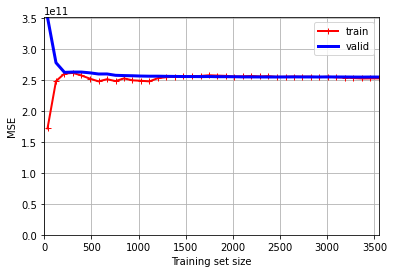

In [47]:
# Generate learning curves with MSE
train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X_train_linear, y_train, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_mean_squared_error")

# Negate the scores and compute the mean across the folds
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

# Plot learning curves
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# Beautify and configure plot
plt.xlabel("Training set size")
plt.ylabel("MSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, train_sizes[-1], 0, max(train_errors.max(), valid_errors.max())])

# Save and show the plot
plt.savefig("mse_learning_curves_plot")
plt.show()

# Section F: Polynomial

## Part 1:Polynomial Regression with Normal Equation and Cross-Validation

### Polynomial regression and k-fold cross validation

In [48]:
poly_degree = 2 

# Transform features to polynomial
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

In [49]:
# Normalize the metrics
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# model = LinearRegressionNormalEquation()
model = LinearRegression()
model.fit(X_train_poly, y_train.ravel())

y_pred = model.predict(X_test_poly)
mse_normal = mean_squared_error(y_test.ravel(), y_pred)
print(f"Linear Regression (Normal Equation) - MSE: {mse_normal:.2f}")

Linear Regression (Normal Equation) - MSE: 64508122141.95


In [50]:
mse_cv = cross_validate_model(model, X_train_poly, y_train.ravel(), k=3)
print(f"Linear Regression (Normal Equation) - 3-Fold CV MSE: {mse_cv:.2f}")

Linear Regression (Normal Equation) - 3-Fold CV MSE: 65915868798.42


### SGD for polynomial regression
Observation:
* Training and Validation MSE Convergence: Both the training and validation MSE decrease rapidly and converge closely, indicating that the model is learning effectively without significant overfitting or underfitting. The close match between the two curves suggests a good generalization from the training data to the validation set.

In [51]:
sgd_model, y_pred_sgd, mse_sgd = create_sgd_model(X_train_poly_scaled, y_train, X_test_poly_scaled, y_test, 0.01, 1000, 1e-5)
print(f"SGD - MSE: {mse_sgd:.2f}")

SGD - MSE: 85112190016.13


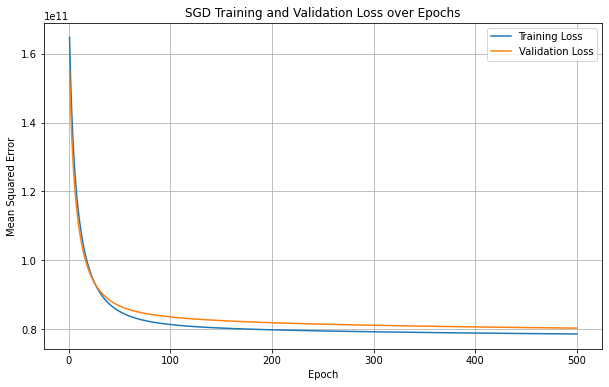

In [52]:
sgd_train_and_plot_loss(X_train_poly_scaled, y_train, X_test_poly_scaled, y_test, 500)

## Part 2: Ridge, Lasso, and Elastic Net Regularization
Observations:

* Ridge Regression:

    * As alpha increases (0.01 to 1), the test MSE increases slightly. This indicates that higher regularization with Ridge tends to slightly worsen the model's performance in this case, though the impact is not dramatic.
* Lasso Regression:

    * The test MSE remains almost constant across different alpha values. This suggests that Lasso regularization, with these specific alpha values, is not significantly affecting the model’s performance. It may indicate that the model is already fairly sparse, or the regularization strength is not enough to make a noticeable impact.

* Elastic Net Regression:

    * Test MSE increases substantially as alpha increases. This suggests that the Elastic Net model becomes less effective with stronger regularization, possibly because it is applying both L1 and L2 penalties, leading to excessive shrinkage of coefficients.

Overall Conclusion: Ridge Regression (with lower alpha values) performs best on this dataset, yielding lower test MSE compared to Lasso and Elastic Net, with Ridge at alpha = 0.01 having the lowest test MSE (73182275267.76). Elastic Net, particularly with higher alpha values, performs worst.

In [53]:
# Define alpha values for regularization
alphas = [0.01, 0.1, 1]

ridge_mse = []
lasso_mse = []
elastic_net_mse = []

# Ridge Regression
for alpha in alphas:
    mse = compute_mse(Ridge, X_train_poly_scaled, y_train, X_test_poly_scaled, y_test, alpha=alpha)
    ridge_mse.append(mse)
    print(f"Ridge Regression (alpha={alpha}) - Test MSE: {mse:.2f}")

# Lasso Regression
for alpha in alphas:
    mse = compute_mse(Lasso, X_train_poly_scaled, y_train, X_test_poly_scaled, y_test, alpha=alpha)
    lasso_mse.append(mse)
    print(f"Lasso Regression (alpha={alpha}) - Test MSE: {mse:.2f}")

# Elastic Net Regression
for alpha in alphas:
    mse = compute_mse(ElasticNet, X_train_poly_scaled, y_train, X_test_poly_scaled, y_test, alpha=alpha, l1_ratio=0.5)
    elastic_net_mse.append(mse)
    print(f"Elastic Net Regression (alpha={alpha}) - Test MSE: {mse:.2f}")

Ridge Regression (alpha=0.01) - Test MSE: 73182275267.76
Ridge Regression (alpha=0.1) - Test MSE: 73411595909.95
Ridge Regression (alpha=1) - Test MSE: 74554542359.41
Lasso Regression (alpha=0.01) - Test MSE: 76263420062.86
Lasso Regression (alpha=0.1) - Test MSE: 76263309720.04
Lasso Regression (alpha=1) - Test MSE: 76262214149.50
Elastic Net Regression (alpha=0.01) - Test MSE: 92190751626.87
Elastic Net Regression (alpha=0.1) - Test MSE: 144950906039.43
Elastic Net Regression (alpha=1) - Test MSE: 205320604222.47


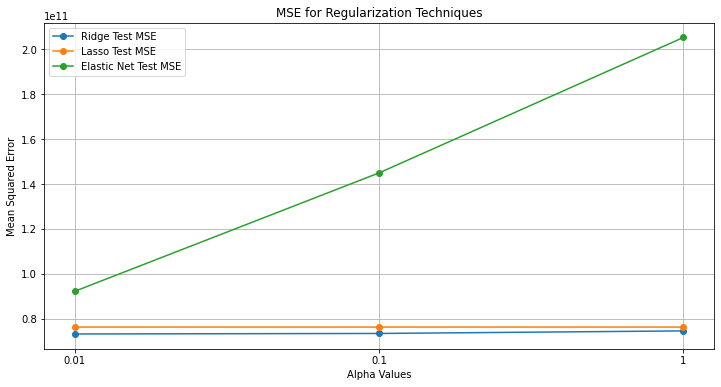

In [54]:
# Plot MSE for different regularization techniques
labels = ['Ridge', 'Lasso', 'Elastic Net']
mse_values = [ridge_mse, lasso_mse, elastic_net_mse]

plt.figure(figsize=(12, 6))
x = np.arange(len(alphas))

for i, label in enumerate(labels):
    plt.plot(x, mse_values[i], marker='o', label=f'{label} Test MSE')

plt.xticks(x, alphas)
plt.xlabel('Alpha Values')
plt.ylabel('Mean Squared Error')
plt.title('MSE for Regularization Techniques')
plt.legend()
plt.grid()
plt.show()

## Part 3: Hyperparameter tuning and model description

In [65]:
batch_sizes = [16, 32, 64]
learning_rates = [0.001, 0.01, 0.1]

results_poly = {}

results_poly = hyperparameter_tuning(batch_sizes, learning_rates, results_poly, X_train_poly_scaled, y_train, X_test_poly_scaled, y_test)
best_params_poly = best_hyperparameters(results_poly)
print(f"The lowest MSE is for Batch_size: {best_params_poly[0]} and Learning Rate: {best_params_poly[1]}")

The lowest MSE is for Batch_size: 16 and Learning Rate: 0.001


### Description of models
1. Polynomial Regression:

    1. Description: Polynomial regression extends linear regression by introducing polynomial features of the input variables. Instead of fitting a straight line, it fits a curve that can capture non-linear relationships between the independent and dependent variables. This is achieved by adding powers of the input features (e.g., 𝑥, 𝑥^2, 𝑥^3, etc.) to the model, allowing it to model more complex patterns. The complexity of the model is determined by the degree of the polynomial. A higher degree allows for more complex curves but also increases the risk of overfitting.
    2. Hyperparameter Tuning: The main hyperparameter in polynomial regression is the degree of the polynomial, which controls how many higher-order terms are included in the model. A low-degree polynomial might underfit the data, while a high-degree polynomial might overfit. Therefore, tuning the degree using cross-validation can help find the optimal balance between bias and variance.

2. Ridge Regression:

    1. Description: Ridge regression is a type of linear regression with L2 regularization, which adds a penalty to the size of the coefficients. This helps to prevent overfitting by shrinking the coefficients, especially in cases of multicollinearity.
    2. Hyperparameter Tuning: The key hyperparameter is the regularization strength, alpha. Larger values of alpha will result in greater regularization, reducing model complexity but possibly underfitting the data. Tuning involves selecting an optimal value for alpha (e.g., via cross-validation).

3. Lasso Regression:

    1. Description: Lasso regression uses L1 regularization, which not only shrinks the coefficients but can set some of them to zero, effectively performing feature selection.
    2. Hyperparameter Tuning: Similar to Ridge, Lasso's alpha is the hyperparameter that controls regularization strength. Tuning alpha allows balancing between model fit and sparsity of features.

4. Elastic Net:

    1. Description: Elastic Net combines both L1 and L2 regularization (Ridge and Lasso). It aims to get the best of both worlds by controlling multicollinearity and performing feature selection.
    2. Hyperparameter Tuning: There are two main hyperparameters: alpha, which controls the overall strength of regularization, and l1_ratio, which controls the balance between L1 and L2 penalties. Tuning these parameters allows controlling the regularization balance for optimal performance.

5. Stochastic Gradient Descent (SGD) Regression:

    1. Description: SGD is an iterative method used for optimizing models, especially with large datasets. It updates the weights gradually based on each training sample, which allows for faster processing of large datasets compared to normal form methods.
    2. Hyperparameter Tuning: The main hyperparameters are learning rate (eta0), batch size (the number of samples processed before updating the model), and maximum iterations (max_iter). Fine-tuning these parameters can improve the convergence and performance of the model.

### Learning curve
Observations:
* The training and validation curves are very close to each other throughout, particularly after the initial sharp drop. This suggests that the model generalizes well to unseen data and is not overfitting.

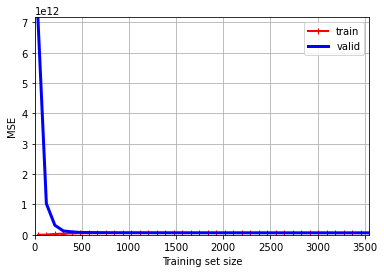

In [56]:
# Generate learning curves with MSE
train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X_train_poly, y_train, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_mean_squared_error")

# Negate the scores and compute the mean across the folds
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

# Plot learning curves
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# Beautify and configure plot
plt.xlabel("Training set size")
plt.ylabel("MSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, train_sizes[-1], 0, max(train_errors.max(), valid_errors.max())])

# Save and show the plot
plt.savefig("mse_learning_curves_plot")
plt.show()

# Section G

## Part 1: Prediction of test labels and evaluation metric

### Linear regression final prediction

In [57]:
# Models used in this exercise
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=0.01),
    'Lasso Regression': Lasso(alpha=0.01),
    'Elastic Net': ElasticNet(alpha=0.01, l1_ratio=0.5),
    'SGD Regression': SGDRegressor(max_iter=1000, eta0=0.01, tol=1e-5, random_state=42, warm_start=True)
}

# Initializing a dictionary to store the results
final_result = {}

# Iterating over all models run to check which is the best model
for model_name, model in models.items():
    model.fit(X_train_linear, y_train)  
    predictions_linear = model.predict(X_test_linear)  
    mse_linear = mean_squared_error(y_test, predictions_linear)
    r2_linear = r2_score(y_test, predictions_linear)
    
    # Append the results to the dict
    final_result[model_name] = {'MSE': mse_linear, 'R2': r2_linear}

In [58]:
final_result

{'Linear Regression': {'MSE': 234922174031.57138, 'R2': 0.1907514843652408},
 'Ridge Regression': {'MSE': 234922213850.06335, 'R2': 0.1907513472004302},
 'Lasso Regression': {'MSE': 234922175495.93707, 'R2': 0.1907514793208649},
 'Elastic Net': {'MSE': 235110938531.86044, 'R2': 0.19010123756630337},
 'SGD Regression': {'MSE': 235198633929.02347, 'R2': 0.189799148713794}}

### Polynomial regression final prediction

In [59]:
# Models used in this exercise
models = {
    'Polynomial Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=0.01),
    'Lasso Regression': Lasso(alpha=0.01),
    'Elastic Net': ElasticNet(alpha=0.01, l1_ratio=0.5),
    'SGD Regression': SGDRegressor(max_iter=1000, eta0=0.01, tol=1e-5, random_state=42, warm_start=True)
}

# Initializing a dictionary to store the results
final_result = {}

# Iterating over all models run to check which is the best model
for model_name, model in models.items():
    model.fit(X_train_poly, y_train)  # Fit model to polynomial features
    predictions_poly = model.predict(X_test_poly)  # Predict using polynomial features
    mse_poly = mean_squared_error(y_test, predictions_poly)  # Cross-validation MSE
    r2_poly = r2_score(y_test, predictions_linear)
    
    # Append the results to the dict
    final_result[model_name] = {'MSE': mse_poly, 'R2': r2_poly}

In [60]:
# MSE for all models
final_result

{'Polynomial Regression': {'MSE': 64508122141.952896, 'R2': 0.189799148713794},
 'Ridge Regression': {'MSE': 67493431583.844925, 'R2': 0.189799148713794},
 'Lasso Regression': {'MSE': 76263454962.75017, 'R2': 0.189799148713794},
 'Elastic Net': {'MSE': 84015204185.34444, 'R2': 0.189799148713794},
 'SGD Regression': {'MSE': 1.497350471581172e+42, 'R2': 0.189799148713794}}

In [61]:
# Since linear regression is performing the best we score the test data on linear regression
best_model = LinearRegression()
best_model.fit(X_test_poly, y_test)
final_predictions = model.predict(X_test_poly)

## Part 2 Summary and future scope

Summary:
The final analysis shows that polynomial regression models outperform linear models in terms of error reduction, indicating that the data exhibits non-linear relationships that linear models struggle to capture. Although the polynomial models reduce the error significantly, all models, including polynomial ones, show relatively low R² values (~0.19), meaning they explain only a modest amount of variance in the data. Regularization methods like Ridge and Lasso Regression had minimal impact, with performance similar to standard linear models. The SGD Regression in the polynomial model demonstrated instability, likely due to improper hyperparameter tuning. Overall, while polynomial models offer better performance, further tuning, especially for SGD, and exploration of different polynomial degrees may lead to additional improvements.

Key observations:
1. R² scores are consistent across models: All models have relatively similar R² values (around 0.19), meaning the variance explained by the models is consistent but relatively low.
2. Ridge and Lasso perform similarly: Both in linear and polynomial models, Ridge and Lasso regression models perform similarly to each other and to the baseline models. The regularization does not significantly impact the performance for these datasets.
3. SGD Regression (Polynomial) shows extreme instability: The MSE value for the SGD Regression in the polynomial model is excessively large (~1.5 × 10^42), indicating that the model is experiencing numerical instability. This could be due to improper tuning of hyperparameters such as the learning rate or batch size.
This could be due to:
    1. Poor convergence, as SGD is sensitive to learning rate and the dataset’s scaling.
    2. The model might have diverged, resulting in such high values. You might want to try normalizing or scaling the features, adjusting the learning rate, or reducing the number of iterations. 
4. Low MSE of 0.22 indicates that the data is suitable for linear regression and the model is fitting well to the curve

Future Work:

1. Model Improvement: Future work could involve exploring more sophisticated models, such as tree-based models (e.g., Random Forest or Gradient Boosting) or deep learning models, which might capture nonlinear relationships better than linear models.
2. Feature Engineering: Additional feature engineering could improve model performance, especially by creating interactions or higher-order features beyond polynomial transformations.
3. Hyperparameter Optimization: Automated hyperparameter tuning methods like grid search or Bayesian optimization can be further explored to fine-tune SGD more systematically.
4. Handling Imbalanced Data: If the dataset is imbalanced, techniques like oversampling, undersampling, or synthetic data generation (e.g., SMOTE) could be applied to balance the target variable distribution, improving model fairness.
5. For SGD investigate polynomial degrees beyond the current one to see if there are more improvements